# Использование RNN в задаче машинного перевода

### 1 Импорт зависимостей, установка констант

In [31]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Subset

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(f"Using device: {device}")

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

!pip install jiwer

Using device: cuda


In [32]:
BATCH_SIZE = 512
MAX_LENGTH = 10

DATA_PATH = '../data/'
LOGS_PATH = './logs'

### 2 Подготовка данных для обучения модели

#### 2.1 Подготовка датасета

Подготовим датасет для обучения модели. Для этого соберем все пары из исходного файла и запишем их в новый в формат: <b><Последовательность исходного языка>\t<Переведенная последовательность><b>

In [33]:
def process_line(line):
    parts = line.split('\t')
    if len(parts) >= 2:
        return f"{parts[0].strip()}\t{parts[1].strip()}\n"
    return None

def transform_file(filepath: str, from_lang: str, to_lang: str) -> None:
    output_filepath = f"{DATA_PATH}{from_lang}-{to_lang}.txt"
    with open(filepath, "r", encoding="utf-8") as infile, open(output_filepath, "w", encoding="utf-8") as outfile:
        for line in infile:
            processed = process_line(line)
            if processed:
                outfile.write(processed)

transform_file(f"{DATA_PATH}rus.txt", "eng", "rus")

#### 2.2 Подготовка интсансов обрабатываемых языков

In [34]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD", 3: "UNK"}
        self.word2index = {"SOS": 0, "EOS": 1, "PAD": 2, "UNK": 3}
        self.n_words = 4

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [35]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Zа-яА-Я]+", " ", s)

    return s.strip()

In [36]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open(f'{DATA_PATH}%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [37]:
_, _, pairs = readLangs("eng", "rus")
pairs

Reading lines...


[['go', 'марш'],
 ['go', 'иди'],
 ['go', 'идите'],
 ['hi', 'здравствуите'],
 ['hi', 'привет'],
 ['hi', 'хаи'],
 ['hi', 'здрасте'],
 ['hi', 'здорово'],
 ['run', 'беги'],
 ['run', 'бегите'],
 ['run', 'беги'],
 ['run', 'бегите'],
 ['who', 'кто'],
 ['wow', 'вот это да'],
 ['wow', 'круто'],
 ['wow', 'здорово'],
 ['wow', 'ух ты'],
 ['wow', 'ого'],
 ['wow', 'вах'],
 ['fire', 'огонь'],
 ['fire', 'пожар'],
 ['help', 'помогите'],
 ['help', 'на помощь'],
 ['help', 'спасите'],
 ['hide', 'прячься'],
 ['hide', 'прячьтесь'],
 ['jump', 'прыгаи'],
 ['jump', 'прыгаите'],
 ['jump', 'прыгаи'],
 ['jump', 'прыгаите'],
 ['stay', 'оставаися'],
 ['stay', 'оставаитесь'],
 ['stay', 'останься'],
 ['stay', 'останьтесь'],
 ['stop', 'стои'],
 ['stop', 'остановитесь'],
 ['stop', 'остановись'],
 ['wait', 'подожди'],
 ['wait', 'подождите'],
 ['wait', 'ждите'],
 ['wait', 'жди'],
 ['wait', 'ждите'],
 ['wait', 'подожди'],
 ['wait', 'подождите'],
 ['do it', 'сделаи это'],
 ['go on', 'продолжаи'],
 ['go on', 'продолжаите'],

Since there are a *lot* of example sentences and we want to train
something quickly, we\'ll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we\'re filtering to sentences that translate to
the form \"I am\" or \"He is\" etc. (accounting for apostrophes replaced
earlier).


In [38]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-   Read text file and split into lines, split lines into pairs
-   Normalize text, filter by length and content
-   Make word lists from sentences in pairs


In [39]:
def prepareData(lang1, lang2, reverse=False, partition=1):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)

    pairs = pairs[0:int(len(pairs) * partition)]

    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'rus', False)

print(len(pairs))
print(random.choice(pairs))

Reading lines...
Read 399919 sentence pairs
Trimmed to 360841 sentence pairs
Counting words...
Counted words:
eng 14762
rus 48575
360841
['tom said you would understand', 'том сказал что вы поимете']


In [40]:
from torch.utils.data import random_split

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, partition=1):
    input_lang, output_lang, pairs = prepareData('eng', 'rus', False, partition=partition)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    full_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                              torch.LongTensor(target_ids).to(device))

    train_size = int(0.85 * len(full_data))
    val_size = len(full_data) - train_size
    train_data, val_data = random_split(full_data, [train_size, val_size])

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    val_sampler = RandomSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return input_lang, output_lang, train_dataloader, val_dataloader

### 3 Создание архитектуры нейронных сетей

#### 3.1 Создание архитектуры простой LSTM сети

Описание класса енкодера

In [41]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Описание класса декодера с механизмом внимания

In [42]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Общий seq-to-seq класс модели

In [43]:
class Seq2SeqLstmModel(nn.Module):
    def __init__(self, input_lang_vocab_size, output_lang_vocab_size, hidden_size, dropout_p=0.1):
        super(Seq2SeqLstmModel, self).__init__()
        self.hidden_size = hidden_size

        self.encoder = EncoderRNN(input_lang_vocab_size, hidden_size, dropout_p).to(device)
        self.decoder = AttnDecoderRNN(hidden_size, output_lang_vocab_size, dropout_p).to(device)

    def forward(self, input_tensor, target_tensor=None, teacher_forcing_ratio=0.5):
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)

        if isinstance(encoder_hidden, tuple):
            decoder_hidden = (
                encoder_hidden[0],
                encoder_hidden[1]
            )
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs, decoder_hidden, attentions = self.decoder(
            encoder_outputs, decoder_hidden, target_tensor
        )

        return decoder_outputs, attentions

#### 3.2 Создание архитектуры GRU сети

Используется предобученный Word2Vec для создания эмбеддингов, также увеличено число слоев для nn.GRU до 2. Помимо этого, используются hidden'ы большего размера (300 вместо 128)

Описание класса енкодера

In [44]:
class GEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, word2vec_model=None, dropout_p=0.1):
        super(GEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.word2vec_model = word2vec_model

        if self.word2vec_model:
            self.embedding = nn.Embedding(input_size, self.word2vec_model.vector_size)
            self.init_embeddings()
            self.projection = nn.Linear(self.word2vec_model.vector_size, hidden_size)
        else:
            self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=2)
        self.dropout = nn.Dropout(dropout_p)

    def init_embeddings(self):
        embedding_matrix = self.embedding.weight.data

        for word, idx in input_lang.word2index.items():
            if word in self.word2vec_model:
                embedding_matrix[idx] = torch.tensor(
                    self.word2vec_model[word], dtype=torch.float32
                )
            else:
                embedding_matrix[idx] = torch.zeros(self.word2vec_model.vector_size)

        self.embedding.weight.data.copy_(embedding_matrix)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        if self.word2vec_model:
            embedded = self.projection(embedded)
        output, hidden = self.gru(embedded)

        return output, hidden

Описание класса декодера с механизмом внимания

In [45]:
class GBahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GBahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class GAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, word2vec_model=None, num_layers=2, dropout_p=0.1):
        super(GAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.word2vec_model = word2vec_model
        self.num_layers = num_layers

        if self.word2vec_model:
            self.embedding = nn.Embedding(output_size, self.word2vec_model.vector_size)
            self.init_embeddings()
            self.projection = nn.Linear(self.word2vec_model.vector_size, hidden_size)
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention = GBahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def init_embeddings(self):
        embedding_matrix = self.embedding.weight.data

        for word, idx in output_lang.word2index.items():
            if word in self.word2vec_model:
                embedding_matrix[idx] = torch.tensor(
                    self.word2vec_model[word], dtype=torch.float32
                )
            else:
                embedding_matrix[idx] = torch.zeros(self.word2vec_model.vector_size)

        self.embedding.weight.data.copy_(embedding_matrix)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        if self.word2vec_model:
            embedded = self.projection(embedded)

        query = hidden[-1].unsqueeze(1)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Общий seq-to-seq класс модели

In [46]:
class Seq2SeqGruModel(nn.Module):
    def __init__(self, input_lang_vocab_size, output_lang_vocab_size, hidden_size, word2vec_model=None, dropout_p=0.1):
        super(Seq2SeqGruModel, self).__init__()
        self.hidden_size = hidden_size

        self.encoder = GEncoderRNN(input_lang_vocab_size, hidden_size, word2vec_model, dropout_p)
        self.decoder = GAttnDecoderRNN(hidden_size, output_lang_vocab_size, word2vec_model, num_layers=2, dropout_p=dropout_p)

    def forward(self, input_tensor, target_tensor=None, teacher_forcing_ratio=0.5):
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, decoder_hidden, attentions = self.decoder(
            encoder_outputs, encoder_hidden, target_tensor
        )

        return decoder_outputs, attentions

### 4 Обучение реализованных моделей

#### 4.1 Вспомогательные методы для валидации и анализа работы модели

Методы для отображения перевода

In [47]:
def evaluate(model, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).to(device)
        decoder_outputs, attentions = model(input_tensor)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze(0)

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words, attentions

def evaluateRandomly(model, n=10):
    for i in range(n):
        pair = random.choice(pairs)

        print('>', pair[0])
        print('=', pair[1])

        output_words, _ = evaluate(model, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        print('<', output_sentence)
        print('')

Метод для валидации работы модели на основе wer, cer

In [48]:
import jiwer

def validate(val_dataloader, model):
    all_references = []
    all_hypotheses = []

    model.eval()

    with torch.no_grad():
        for data in val_dataloader:
            input_tensor, target_tensor = data

            target_sentences = [
                ' '.join(output_lang.index2word[idx.item()] for idx in tgt if idx.item() != PAD_token)
                for tgt in target_tensor
            ]
            all_references.extend(target_sentences)

            for input_t, target_t in zip(input_tensor, target_tensor):
                input_sentence = ' '.join(input_lang.index2word[idx.item()] for idx in input_t if idx.item() != PAD_token)
                hypothesis, _ = evaluate(model, input_sentence, input_lang, output_lang)
                all_hypotheses.append(' '.join(hypothesis))

    wer = jiwer.wer(all_references, all_hypotheses)
    cer = jiwer.cer(all_references, all_hypotheses)

    return wer, cer


Метод для визуализации Loss-функции

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points, title="Training Loss", xlabel="Epochs", ylabel="Loss"):
    plt.figure(figsize=(10, 6))

    fig, ax = plt.subplots()

    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)

    ax.plot(points, label="Loss", color='blue', linewidth=2)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    ax.set_title(title, fontsize=16)

    ax.grid(True, linestyle='--', alpha=0.7)

    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

#### 4.2 Методы обучения модели

In [50]:
def train_epoch(dataloader, model, optimizer, criterion, teacher_forcing_ratio=0.5):
    model.train()
    torch.cuda.empty_cache()
    total_loss = 0

    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        optimizer.zero_grad()

        decoder_outputs, attentions = model(input_tensor, target_tensor, teacher_forcing_ratio=teacher_forcing_ratio)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        if torch.isnan(loss):
            print("NaN detected in loss!")
            break

        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is None:
                print(f"NaN detected in gradients of {name}")
                break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [51]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train(train_dataloader, val_dataloader, model, n_epochs, learning_rate=0.001,
          teacher_forcing_ratio=0.5, print_every=100, plot_every=100, validate_every=1):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    writer = SummaryWriter(LOGS_PATH)

    for epoch in tqdm(range(1, n_epochs + 1), desc="Training Epochs", unit="epoch"):
        loss = train_epoch(train_dataloader, model, optimizer, criterion, teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0

            tqdm.write(f'Epoch {epoch}/{n_epochs} - Loss: {print_loss_avg:.4f}')

            writer.add_scalar('Loss/train', print_loss_avg, epoch)

        if epoch % validate_every == 0:
            wer, cer = validate(val_dataloader, model)
            print(f'Validation at Epoch {epoch}: WER = {wer:.4f}, CER = {cer:.4f}')

            writer.add_scalar('WER/validation', wer, epoch)
            writer.add_scalar('CER/validation', cer, epoch)

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            writer.add_scalar('Loss/plot', plot_loss_avg, epoch)

    showPlot(plot_losses)

    writer.close()

In [52]:
import gensim.downloader as api

HIDDEN_SIZE = 128
WORD2VEC_HIDDEN_SIZE = 300

N_EPOCHS = 30
LR = 0.001

input_lang, output_lang, train_dataloader, val_dataloader = get_dataloader(BATCH_SIZE)

input_lang_vocab_size = input_lang.n_words
output_lang_vocab_size = output_lang.n_words
word2vec_model = api.load('word2vec-google-news-300')

seq2seq_lstm_model = Seq2SeqLstmModel(
    input_lang_vocab_size,
    output_lang_vocab_size,
    HIDDEN_SIZE
).to(device)

seq2seq_gru_model = Seq2SeqGruModel(
    input_lang_vocab_size,
    output_lang_vocab_size,
    WORD2VEC_HIDDEN_SIZE,
    word2vec_model=word2vec_model
).to(device)

Reading lines...
Read 399919 sentence pairs
Trimmed to 360841 sentence pairs
Counting words...
Counted words:
eng 14762
rus 48575


Training Epochs:  13%|█▎        | 4/30 [10:09<53:00, 122.35s/epoch]

Epoch 5/30 - Loss: 2.4910


Training Epochs:  17%|█▋        | 5/30 [25:32<3:08:51, 453.26s/epoch]

Validation at Epoch 5: WER = 0.8088, CER = 0.6607


Training Epochs:  30%|███       | 9/30 [34:51<1:03:58, 182.80s/epoch]

Epoch 10/30 - Loss: 1.3228


Training Epochs:  33%|███▎      | 10/30 [48:07<2:15:26, 406.33s/epoch]

Validation at Epoch 10: WER = 0.7582, CER = 0.6022


Training Epochs:  47%|████▋     | 14/30 [57:22<48:04, 180.29s/epoch]

Epoch 15/30 - Loss: 0.9225


Training Epochs:  50%|█████     | 15/30 [1:10:39<1:39:57, 399.82s/epoch]

Validation at Epoch 15: WER = 0.7351, CER = 0.5743


Training Epochs:  63%|██████▎   | 19/30 [1:19:54<32:59, 179.97s/epoch]

Epoch 20/30 - Loss: 0.7167


Training Epochs:  67%|██████▋   | 20/30 [1:33:04<1:06:06, 396.65s/epoch]

Validation at Epoch 20: WER = 0.7242, CER = 0.5614


Training Epochs:  80%|████████  | 24/30 [1:42:18<17:56, 179.35s/epoch]

Epoch 25/30 - Loss: 0.5981


Training Epochs:  83%|████████▎ | 25/30 [1:55:29<33:00, 396.10s/epoch]

Validation at Epoch 25: WER = 0.7169, CER = 0.5531


Training Epochs:  97%|█████████▋| 29/30 [2:04:43<02:59, 179.48s/epoch]

Epoch 30/30 - Loss: 0.5235


Training Epochs: 100%|██████████| 30/30 [2:18:01<00:00, 276.04s/epoch]

Validation at Epoch 30: WER = 0.7124, CER = 0.5485


<Figure size 1000x600 with 0 Axes>

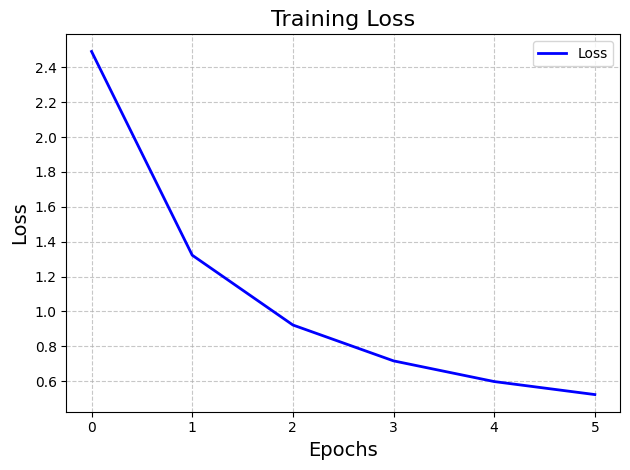

In [ ]:
try:
    train(
        train_dataloader,
        val_dataloader,
        seq2seq_lstm_model,
        N_EPOCHS,
        learning_rate=LR,
        print_every=5,
        plot_every=5,
        validate_every=5
    )
except KeyboardInterrupt as ex:
    print("Interrupt from keyboard")

Training Epochs:  13%|█▎        | 4/30 [16:02<1:23:00, 191.56s/epoch]

Epoch 5/30 - Loss: 1.5730


Training Epochs:  17%|█▋        | 5/30 [32:52<3:51:17, 555.10s/epoch]

Validation at Epoch 5: WER = 0.7198, CER = 0.5590


Training Epochs:  30%|███       | 9/30 [48:39<1:32:51, 265.32s/epoch]

Epoch 10/30 - Loss: 0.4677


Training Epochs:  33%|███▎      | 10/30 [1:05:26<3:04:16, 552.83s/epoch]

Validation at Epoch 10: WER = 0.7024, CER = 0.5388


Training Epochs:  47%|████▋     | 14/30 [1:21:12<1:13:13, 274.58s/epoch]

Epoch 15/30 - Loss: 0.2979


Training Epochs:  50%|█████     | 15/30 [1:37:57<2:17:56, 551.80s/epoch]

Validation at Epoch 15: WER = 0.6992, CER = 0.5353


Training Epochs:  63%|██████▎   | 19/30 [1:53:56<51:08, 278.94s/epoch]

Epoch 20/30 - Loss: 0.2326


Training Epochs:  67%|██████▋   | 20/30 [2:10:47<1:32:40, 556.02s/epoch]

Validation at Epoch 20: WER = 0.6971, CER = 0.5337


Training Epochs:  80%|████████  | 24/30 [2:26:36<27:45, 277.56s/epoch]

Epoch 25/30 - Loss: 0.1982


Training Epochs:  83%|████████▎ | 25/30 [2:43:47<46:42, 560.54s/epoch]

Validation at Epoch 25: WER = 0.6981, CER = 0.5344


Training Epochs:  97%|█████████▋| 29/30 [2:59:38<04:39, 279.01s/epoch]

Epoch 30/30 - Loss: 0.1780


Training Epochs: 100%|██████████| 30/30 [3:16:32<00:00, 393.09s/epoch]

Validation at Epoch 30: WER = 0.6976, CER = 0.5331


<Figure size 1000x600 with 0 Axes>

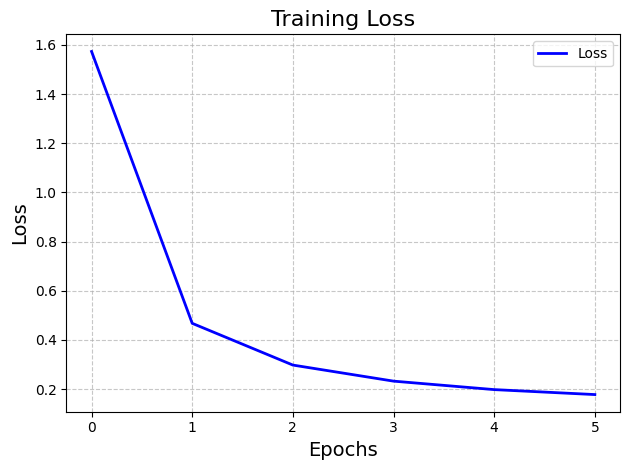

In [23]:
try:
    train(
        train_dataloader,
        val_dataloader,
        seq2seq_gru_model,
        N_EPOCHS,
        learning_rate=LR,
        print_every=5,
        plot_every=5,
        validate_every=5
    )
except KeyboardInterrupt as ex:
    print("Interrupt from keyboard")

#### 4.3 Сохранение обученных моделей

In [53]:
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

    print(f"Model saved to {file_path}")

def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))
    model.eval()

    print(f"Model loaded from {file_path}")

    return model

In [25]:
save_model(seq2seq_lstm_model, 'seq2seq_lstm_model.pth')

save_model(seq2seq_gru_model, 'seq2seq_gru_model.pth')

Model saved to seq2seq_lstm_model.pth
Model saved to seq2seq_gru_model.pth


### 5 Инференс моделей

#### 5.1 Загрузка обученных моделей

In [54]:
seq2seq_lstm_model = Seq2SeqLstmModel(
    input_lang_vocab_size,
    output_lang_vocab_size,
    HIDDEN_SIZE
).to(device)

seq2seq_gru_model = Seq2SeqGruModel(
    input_lang_vocab_size,
    output_lang_vocab_size,
    WORD2VEC_HIDDEN_SIZE,
    word2vec_model=word2vec_model
).to(device)

load_model(seq2seq_lstm_model, 'seq2seq_lstm_model.pth')
load_model(seq2seq_gru_model, 'seq2seq_gru_model.pth')

Model loaded from seq2seq_lstm_model.pth
Model loaded from seq2seq_gru_model.pth


C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\647062938.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


Seq2SeqGruModel(
  (encoder): GEncoderRNN(
    (embedding): Embedding(14762, 300)
    (projection): Linear(in_features=300, out_features=300, bias=True)
    (gru): GRU(300, 300, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): GAttnDecoderRNN(
    (embedding): Embedding(48575, 300)
    (projection): Linear(in_features=300, out_features=300, bias=True)
    (attention): GBahdanauAttention(
      (Wa): Linear(in_features=300, out_features=300, bias=True)
      (Ua): Linear(in_features=300, out_features=300, bias=True)
      (Va): Linear(in_features=300, out_features=1, bias=True)
    )
    (gru): GRU(600, 300, num_layers=2, batch_first=True)
    (out): Linear(in_features=300, out_features=48575, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

#### 5.1 Расчет BLEU-метрики

Функция расчета метрики

In [55]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

def calculate_bleu(model, dataloader, input_lang, output_lang):
    all_references = []
    all_hypotheses = []

    model.eval()
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Calculating BLEU", unit="batch"):
            input_tensor, target_tensor = data
            target_sentences = [
                [output_lang.index2word[idx.item()] for idx in tgt if idx.item() != PAD_token]
                for tgt in target_tensor
            ]
            all_references.extend([[ref] for ref in target_sentences])

            for input_t, target_t in zip(input_tensor, target_tensor):
                input_sentence = ' '.join(input_lang.index2word[idx.item()] for idx in input_t if idx.item() != PAD_token)
                hypothesis, _ = evaluate(model, input_sentence, input_lang, output_lang)
                all_hypotheses.append(hypothesis)

    bleu_score = corpus_bleu(all_references, all_hypotheses)
    return bleu_score

Расчет метрики

In [56]:
calculate_bleu(seq2seq_lstm_model, val_dataloader, input_lang, output_lang)

Calculating BLEU: 100%|████████████████████████████████████████████████████████████| 106/106 [16:39<00:00,  9.43s/batch]


0.1724055850033398

In [57]:
calculate_bleu(seq2seq_gru_model, val_dataloader, input_lang, output_lang)

Calculating BLEU: 100%|████████████████████████████████████████████████████████████| 106/106 [20:12<00:00, 11.44s/batch]


0.2491014343023803

#### 5.2 Обработка рандомных приложений из тренировочного датасета

Для LSTM

In [58]:
seq2seq_lstm_model.eval()

evaluateRandomly(seq2seq_lstm_model, n=5)

> please promise me that you won t do that
= обещаи мне пожалуиста что не сделаешь этого
< обещаи мне пожалуиста что не будешь этого делать <EOS>

> please speak loudly so i can hear you
= говорите громко пожалуиста чтобы я вас слышал
< пожалуиста говори громко чтобы я слышал как ты услышишь <EOS>

> do you like shopping
= вы любите ходить по магазинам
< тебе нравится смотреть по магазинам <EOS>

> i received a letter in english yesterday
= вчера я получил письмо на англииском
< я вчера получил письмо по англиискому <EOS>

> some furniture is put together with glue
= часть мебели склеена
< некоторые мебель с тем как федеральные поставить с водои <EOS>



Для GRU

In [59]:
seq2seq_gru_model.eval()

evaluateRandomly(seq2seq_gru_model, n=5)

> i was afraid to laugh
= я боялся смеяться
< я боялся говорить смеяться <EOS>

> i m glad you volunteered to help
= я рад что вы вызвались помочь
< я рад что ты вызвались помочь <EOS>

> i grew up in this house
= я вырос в этом доме
< я вырос в этом доме <EOS>

> don t tell me you re tired already
= не говори мне что ты уже устала
< только не говори мне что ты уже устала <EOS>

> she wanted to flatter me
= она хотела польстить мне
< она хотела польстить мне <EOS>



#### 5.3 Анализ механизма внимания

Функции для расчета

In [60]:
def show_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(model, input_sentence):
    output_words, attentions = evaluate(model, input_sentence, input_lang, output_lang)

    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

    show_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

def compare_attention_LSTM_vs_GRU(lstm_model, gru_model, input_sentence, input_lang, output_lang):
    lstm_output_words, lstm_attentions = evaluate(lstm_model, input_sentence, input_lang, output_lang)
    gru_output_words, gru_attentions = evaluate(gru_model, input_sentence, input_lang, output_lang)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    cax_lstm = axes[0].matshow(lstm_attentions[0, :len(lstm_output_words), :].cpu().numpy(), cmap='bone')
    fig.colorbar(cax_lstm, ax=axes[0])
    axes[0].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    axes[0].set_yticklabels([''] + lstm_output_words)
    axes[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[0].set_title("Attention (LSTM)")

    cax_gru = axes[1].matshow(gru_attentions[0, :len(gru_output_words), :].cpu().numpy(), cmap='bone')
    fig.colorbar(cax_gru, ax=axes[1])
    axes[1].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    axes[1].set_yticklabels([''] + gru_output_words)
    axes[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[1].set_title("Attention (GRU)")

    plt.tight_layout()
    plt.show()

C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([''] + lstm_output_words)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

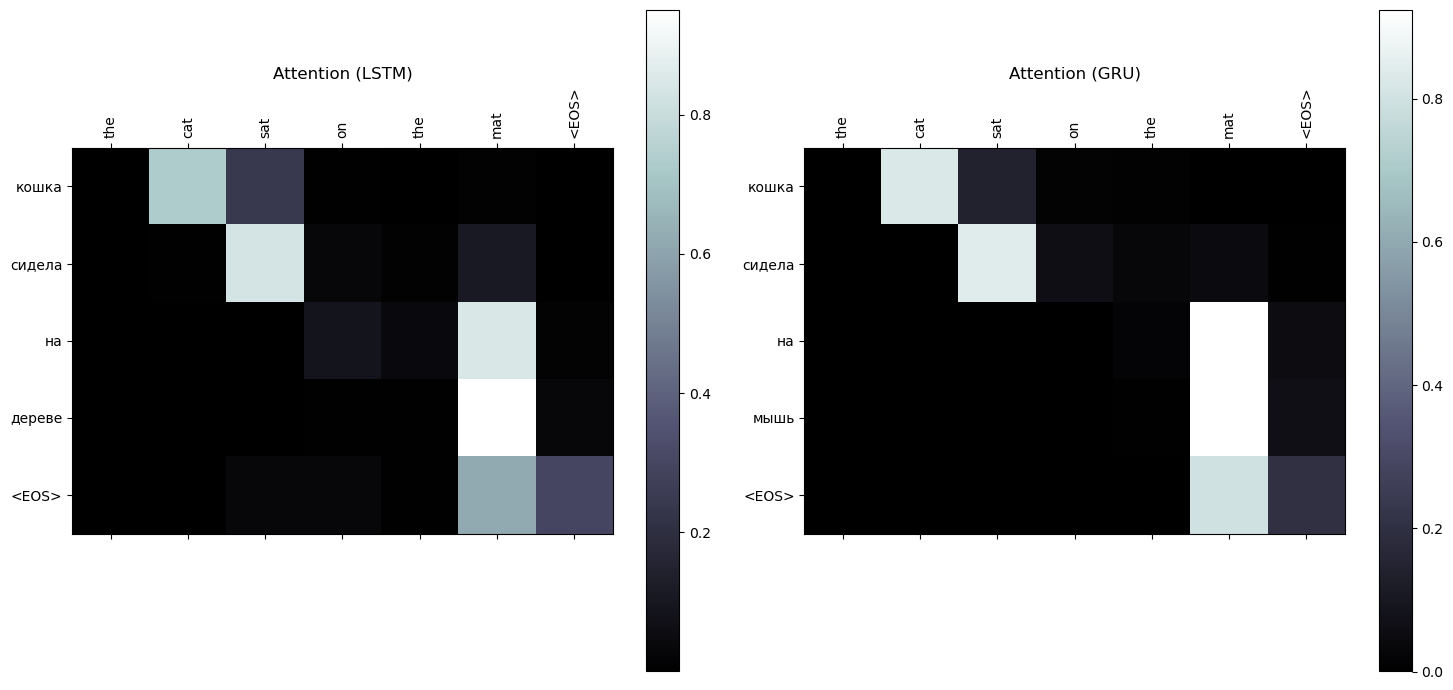

C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([''] + lstm_output_words)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

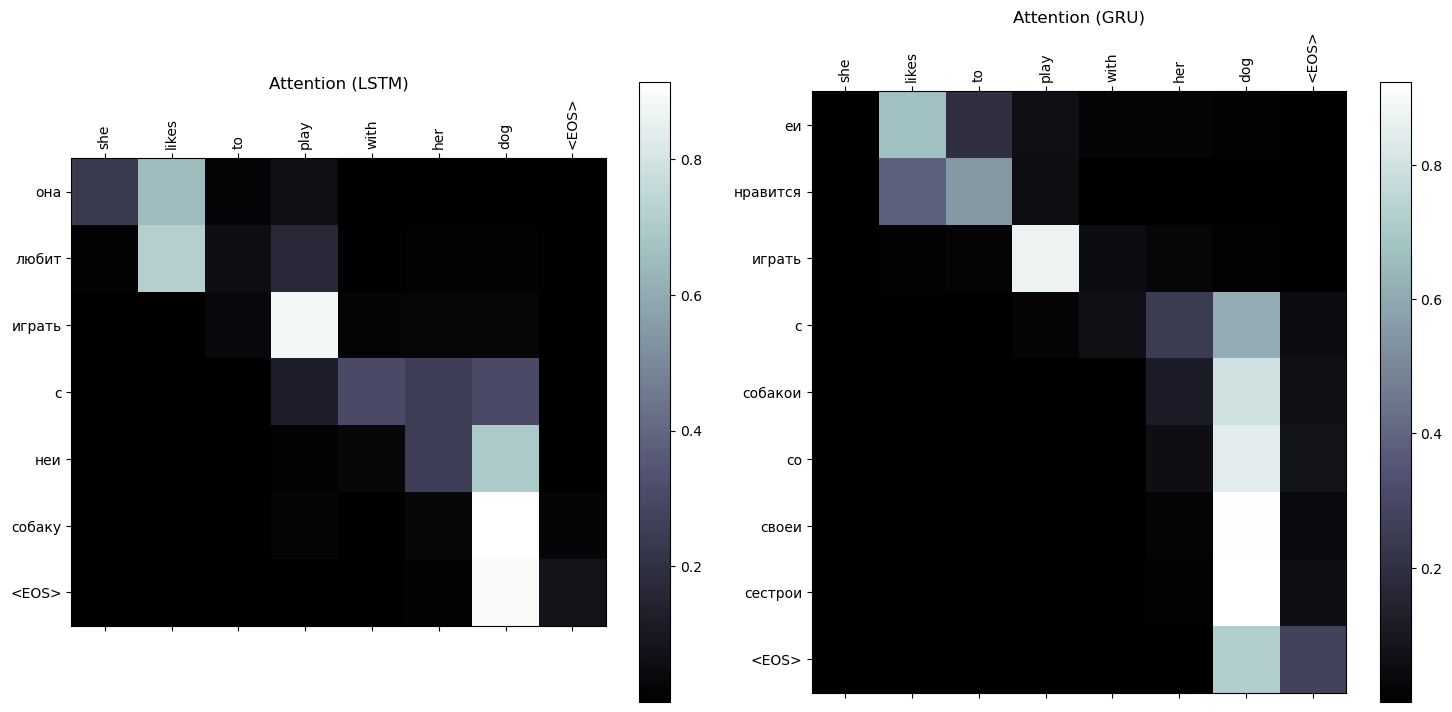

C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([''] + lstm_output_words)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

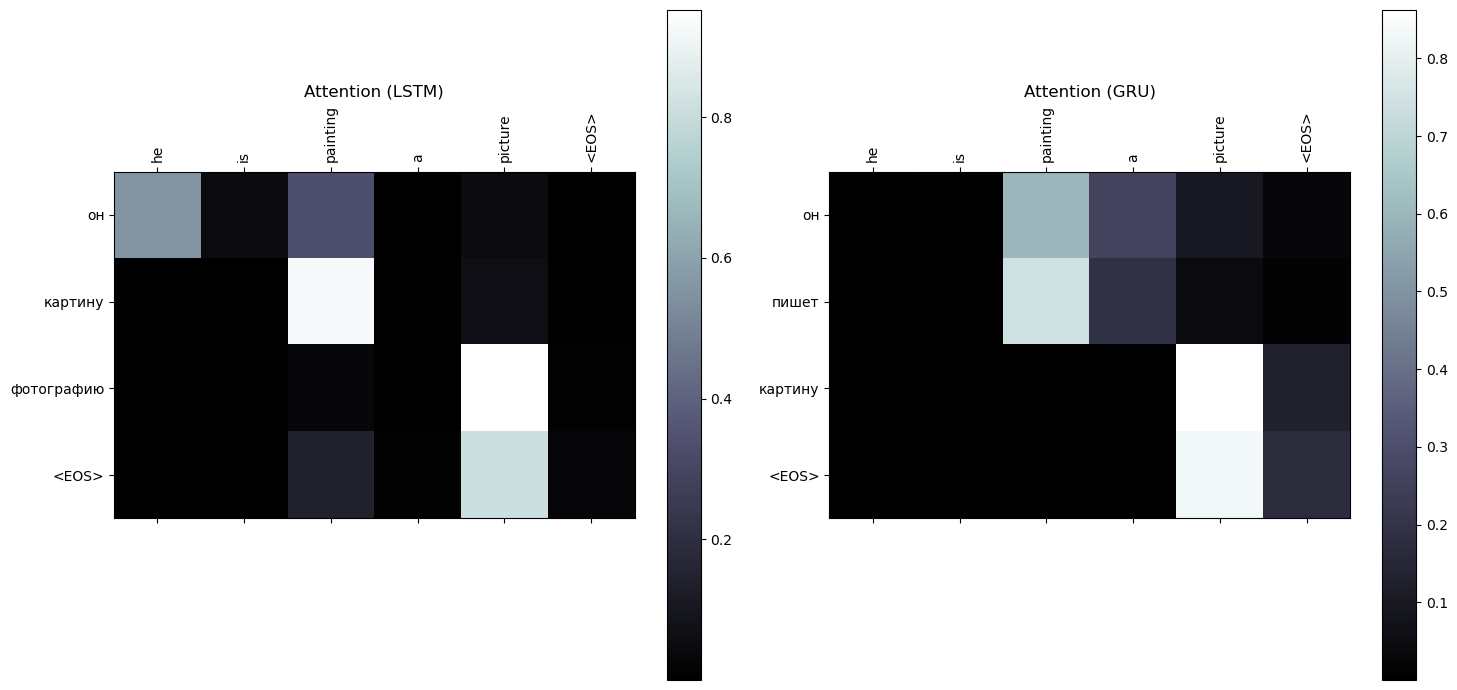

C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([''] + lstm_output_words)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
C:\Users\artrsyf\AppData\Local\Temp\ipykernel_23000\3640503447.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

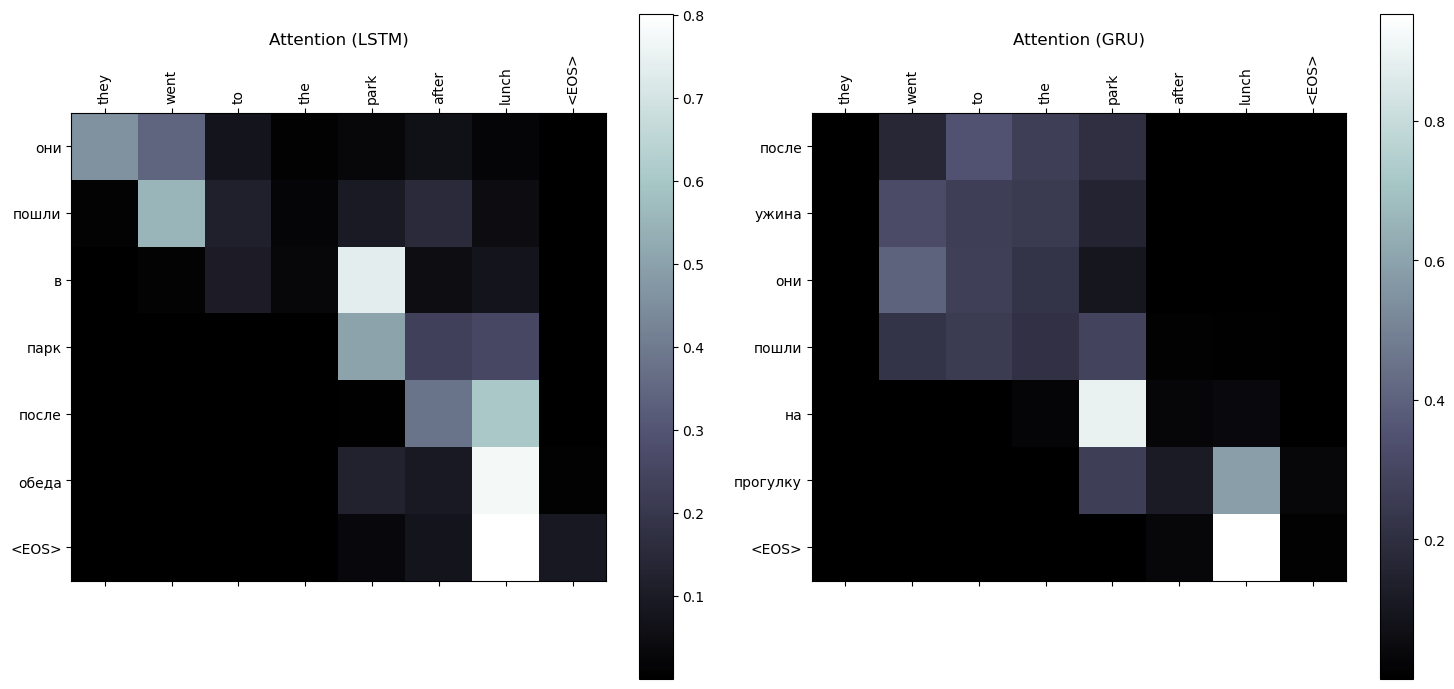

In [63]:
sentences = [
    "the cat sat on the mat",
    "she likes to play with her dog",
    "he is painting a picture",
    "they went to the park after lunch"
]

for sentence in sentences:
    compare_attention_LSTM_vs_GRU(
        seq2seq_lstm_model, 
        seq2seq_gru_model, 
        sentence,
        input_lang,
        output_lang
    )

#### 5.4 Общий анализ результатов перевода

In [64]:
def translateSentence(input_sentence, model):
    print('input>', input_sentence)

    output_words, _ = evaluate(model, input_sentence, input_lang, output_lang)
    output_sentence = ' '.join(output_words)

    print('output<', output_sentence)
    print('')

In [68]:
sentences_to_translate = [
    "you work hard",
    "tom was sick",
    "summer is here",
    "tom will win",
    "i wonder where she lives",
    "you will be there again soon",
    "i rarely make a mistake",
    "i knew all about that",
    "i plan on going there",
    "we are going to swim"
]

for idx, sentence in enumerate(sentences_to_translate):
    print(f"<##### Sentence {idx + 1} #####>")
    print("<-- LSTM -->")
    translateSentence(
        sentence,
        seq2seq_lstm_model
    )

    print("<-- GRU -->")
    translateSentence(
        sentence,
        seq2seq_gru_model
    )

<##### Sentence 1 #####>
<-- LSTM -->
input> you work hard
output< ты слишком много работаешь <EOS>

<-- GRU -->
input> you work hard
output< ты много работаешь <EOS>

<##### Sentence 2 #####>
<-- LSTM -->
input> tom was sick
output< том был болен <EOS>

<-- GRU -->
input> tom was sick
output< том болел больнои <EOS>

<##### Sentence 3 #####>
<-- LSTM -->
input> summer is here
output< лето здесь <EOS>

<-- GRU -->
input> summer is here
output< летом здесь лето <EOS>

<##### Sentence 4 #####>
<-- LSTM -->
input> tom will win
output< том выиграет <EOS>

<-- GRU -->
input> tom will win
output< том выиграет <EOS>

<##### Sentence 5 #####>
<-- LSTM -->
input> i wonder where she lives
output< интересно где она живет <EOS>

<-- GRU -->
input> i wonder where she lives
output< интересно где она живет в жизнь <EOS>

<##### Sentence 6 #####>
<-- LSTM -->
input> you will be there again soon
output< ты скоро будешь там снова <EOS>

<-- GRU -->
input> you will be there again soon
output< ты скоро оп

### 6 Логи tensorboard

#### 6.1 Запуск сервера tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os
import tensorboard

log_dir = "./logs"
os.system(f"tensorboard --logdir={log_dir} --port=6006")

#### 6.2 Графики собранных данных

In [1]:
from IPython.display import SVG, display

SVG_PATH = "./imgs"

Train loss

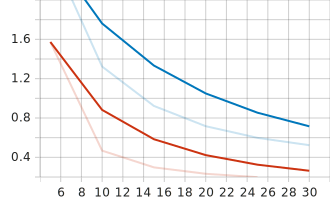

In [4]:
display(SVG(f"{SVG_PATH}/Loss_train.svg"))

WER validation

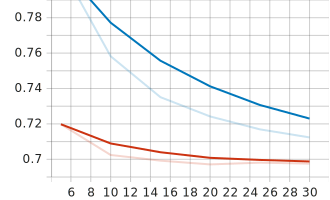

In [5]:
display(SVG(f"{SVG_PATH}/WER_validation.svg"))

CER validation

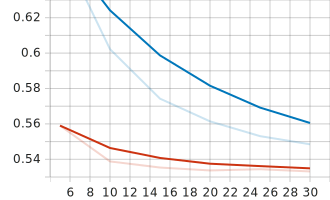

In [6]:
display(SVG(f"{SVG_PATH}/CER_validation.svg"))